# Chapter 2 - Production (Python Code)

In [ ]:
! pip install --upgrade quantecon_book_networks

We begin with some imports.

In [1]:
import quantecon as qe
import quantecon_book_networks
import quantecon_book_networks.input_output as qbn_io
import quantecon_book_networks.plotting as qbn_plt
import quantecon_book_networks.data as qbn_data
ch2_data = qbn_data.production()
default_figsize = (6, 4)
export_figures = False

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as plc
from matplotlib import cm
quantecon_book_networks.config("matplotlib")

## Multisector Models

We start by loading a graph of linkages between 15 US sectors in 2021. 

Our graph comes as a list of sector codes, an adjacency matrix of sales between
the sectors, and a list the total sales of each sector.  

In particular, `Z[i,j]` is the sales from industry `i` to industry `j`, and `X[i]` is the the total sales
of each sector `i`.

In [3]:
codes = ch2_data["us_sectors_15"]["codes"]
Z = ch2_data["us_sectors_15"]["adjacency_matrix"]
X = ch2_data["us_sectors_15"]["total_industry_sales"]

Now we define a function to build coefficient matrices. 

Two coefficient matrices are returned. The backward linkage case, where sales
between sector `i` and `j` are given as a fraction of total sales of sector
`j`. The forward linkage case, where sales between sector `i` and `j` are
given as a fraction of total sales of sector `i`.

In [4]:
def build_coefficient_matrices(Z, X):
    """
    Build coefficient matrices A and F from Z and X via 
    
        A[i, j] = Z[i, j] / X[j] 
        F[i, j] = Z[i, j] / X[i]
    
    """
    A, F = np.empty_like(Z), np.empty_like(Z)
    n = A.shape[0]
    for i in range(n):
        for j in range(n):
            A[i, j] = Z[i, j] / X[j]
            F[i, j] = Z[i, j] / X[i]

    return A, F

A, F = build_coefficient_matrices(Z, X)

### Backward linkages for 15 US sectors in 2021

Here we calculate the hub-based eigenvector centrality of our backward linkage coefficient matrix.

In [5]:
centrality = qbn_io.eigenvector_centrality(A)

Now we use the `quantecon_book_networks` package to produce our plot.

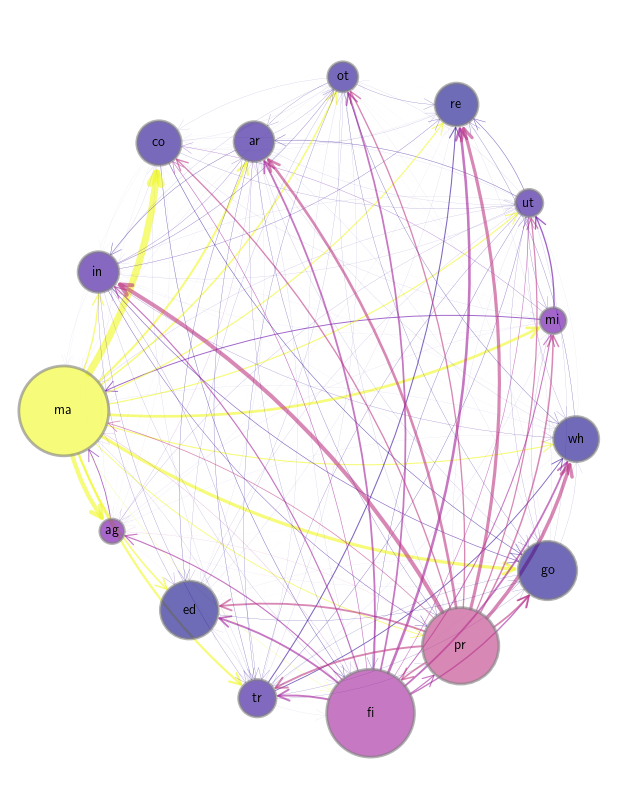

In [6]:
fig, ax = plt.subplots(figsize=(8, 10))
plt.axis("off")
color_list = qbn_io.colorise_weights(centrality, beta=False)
# Remove self-loops
A1 = A.copy()
for i in range(A1.shape[0]):
    A1[i][i] = 0
qbn_plt.plot_graph(A1, X, ax, codes, 
              layout_type='spring',
              layout_seed=5432167,
              tol=0.0,
              node_color_list=color_list) 

if export_figures:
    plt.savefig("figures/input_output_analysis_15.pdf")
plt.show()

### Eigenvector centrality of across US industrial sectors

Now we plot a bar chart of hub-based eigenvector centrality by sector.

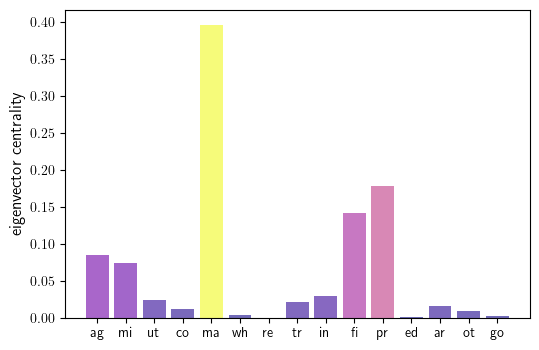

In [7]:
fig, ax = plt.subplots(figsize=default_figsize)
ax.bar(codes, centrality, color=color_list, alpha=0.6)
ax.set_ylabel("eigenvector centrality", fontsize=12)
if export_figures:
    plt.savefig("figures/input_output_analysis_15_ec.pdf")
plt.show()

### Output multipliers across 15 US industrial sectors

Output multipliers are equal to the authority-based Katz centrality measure of
the backward linkage coefficient matrix. 

Here we calculate authority-based
Katz centrality using the `quantecon_book_networks` package.

In [8]:
omult = qbn_io.katz_centrality(A, authority=True)

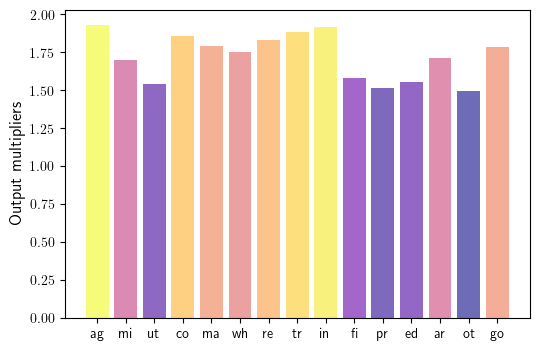

In [9]:
fig, ax = plt.subplots(figsize=default_figsize)
omult_color_list = qbn_io.colorise_weights(omult,beta=False)
ax.bar(codes, omult, color=omult_color_list, alpha=0.6)
ax.set_ylabel("Output multipliers", fontsize=12)
if export_figures:
    plt.savefig("figures/input_output_analysis_15_omult.pdf")
plt.show()

### Forward linkages and upstreamness over US industrial sectors

Upstreamness is the hub-based Katz centrality of the forward linkage
coefficient matrix. 

Here we calculate hub-based Katz centrality.

In [10]:
upstreamness = qbn_io.katz_centrality(F)

Now we plot the network.

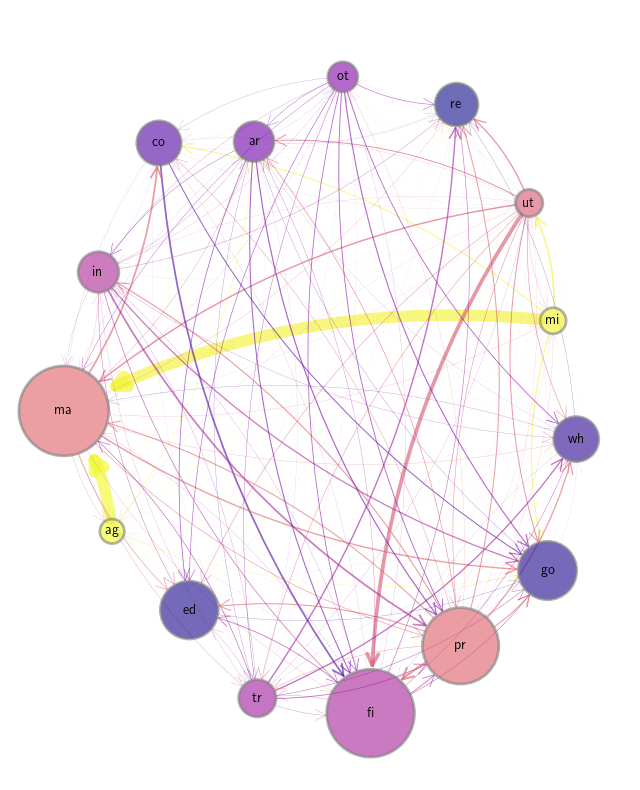

In [11]:
fig, ax = plt.subplots(figsize=(8, 10))
plt.axis("off")
upstreamness_color_list = qbn_io.colorise_weights(upstreamness,beta=False)
# Remove self-loops
for i in range(F.shape[0]):
    F[i][i] = 0
qbn_plt.plot_graph(F, X, ax, codes, 
              layout_type='spring', # alternative layouts: spring, circular, random, spiral
              layout_seed=5432167,
              tol=0.0,
              node_color_list=upstreamness_color_list) 

if export_figures:
    plt.savefig("figures/input_output_analysis_15_fwd.pdf")
plt.show()

### Relative upstreamness of US industrial sectors

Here we produce a barplot of upstreamness.

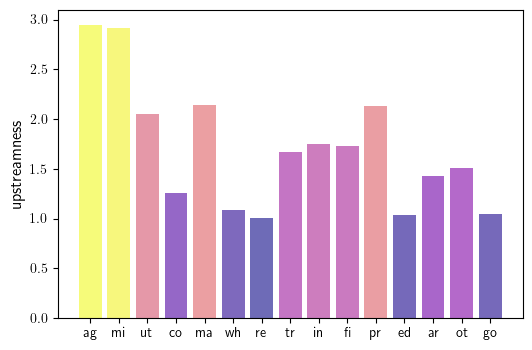

In [12]:
fig, ax = plt.subplots(figsize=default_figsize)
ax.bar(codes, upstreamness, color=upstreamness_color_list, alpha=0.6)
ax.set_ylabel("upstreamness", fontsize=12)
if export_figures:
    plt.savefig("figures/input_output_analysis_15_up.pdf")
plt.show()

### Hub-based Katz centrality of across 15 US industrial sectors

Next we plot the hub-based Katz centrality of the backward linkage coefficient matrix.

In [13]:
kcentral = qbn_io.katz_centrality(A)

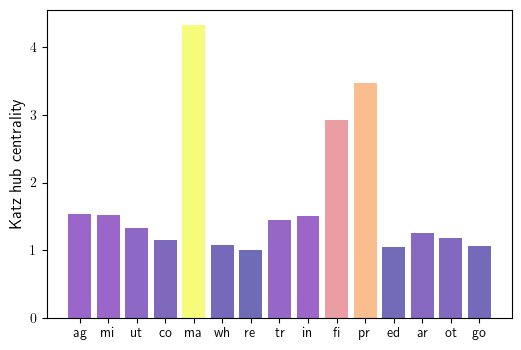

In [14]:
fig, ax = plt.subplots(figsize=default_figsize)
kcentral_color_list = qbn_io.colorise_weights(kcentral,beta=False)
ax.bar(codes, kcentral, color=kcentral_color_list, alpha=0.6)
ax.set_ylabel("Katz hub centrality", fontsize=12)
if export_figures:
    plt.savefig("figures/input_output_analysis_15_katz.pdf")
plt.show()

### The Leontief inverse 𝐿 (hot colors are larger values)

We construct the Leontief inverse matrix from 15 sector adjacency matrix.

In [15]:
I = np.identity(len(A))
L = np.linalg.inv(I - A)

Now we produce the plot.

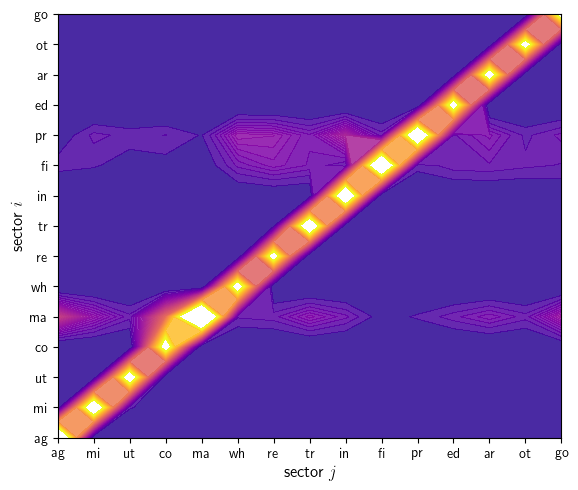

In [16]:
fig, ax = plt.subplots(figsize=(6.5, 5.5))

ticks = range(len(L))

levels = np.sqrt(np.linspace(0, 0.75, 100))

co = ax.contourf(ticks, 
                    ticks,
                    L,
                    levels,
                    alpha=0.85, cmap=cm.plasma)

ax.set_xlabel('sector $j$', fontsize=12)
ax.set_ylabel('sector $i$', fontsize=12)
ax.set_yticks(ticks)
ax.set_yticklabels(codes)
ax.set_xticks(ticks)
ax.set_xticklabels(codes)

if export_figures:
    plt.savefig("figures/input_output_analysis_15_leo.pdf")
plt.show()

### Propagation of demand shocks via backward linkages

We begin by generating a demand shock vector $d$.

In [17]:
N = len(A)
np.random.seed(1234)
d = np.random.rand(N) 
d[6] = 1  # positive shock to agriculture

Now we simulate the demand shock propagating through the economy.

In [18]:
sim_length = 11
x = d
x_vecs = []
for i in range(sim_length):
    if i % 2 ==0:
        x_vecs.append(x)
    x = A @ x

Finally, we plot the shock propagating through the economy.

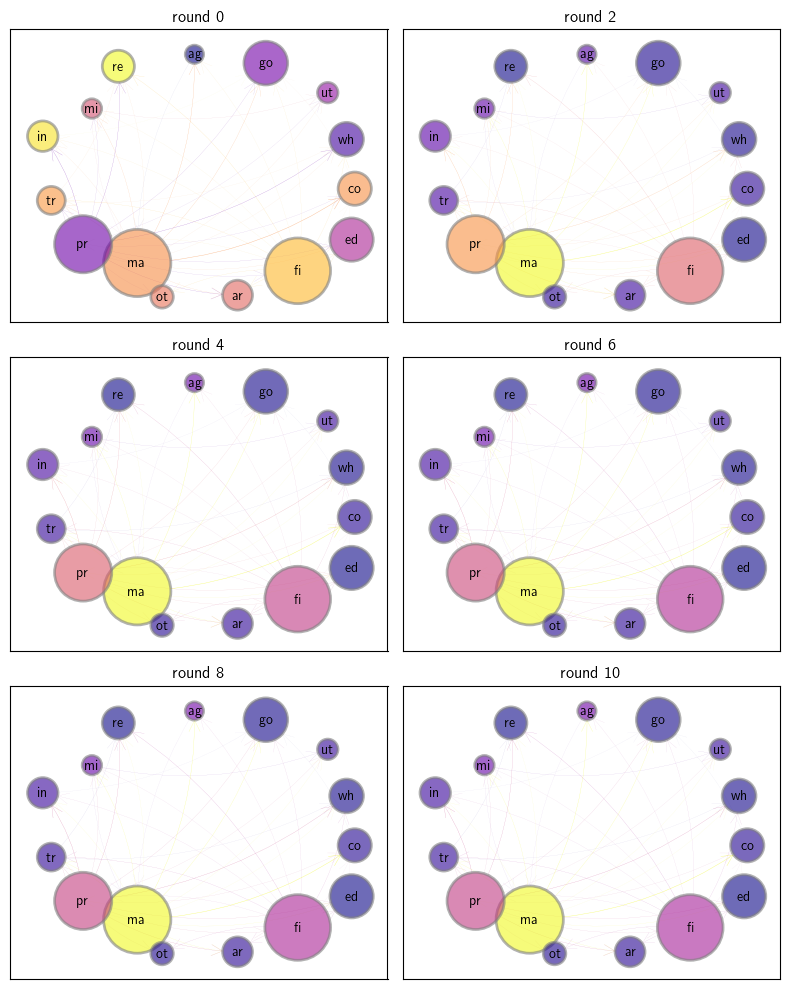

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes = axes.flatten()

for ax, x_vec, i in zip(axes, x_vecs, range(sim_length)):
    if i % 2 != 0:
        pass
    ax.set_title(f"round {i*2}")
    x_vec_cols = qbn_io.colorise_weights(x_vec,beta=False)
    # remove self-loops
    for i in range(len(A)):
        A[i][i] = 0
    qbn_plt.plot_graph(A, X, ax, codes,
                  layout_type='spring',
                  layout_seed=342156,
                  node_color_list=x_vec_cols,
                  node_size_multiple=0.00028,
                  edge_size_multiple=0.8)

plt.tight_layout()
if export_figures:
    plt.savefig("figures/input_output_analysis_15_shocks.pdf")
plt.show()

### Network for 71 US sectors in 2021

We start by loading a graph of linkages between 71 US sectors in 2021.

In [20]:
codes_71 = ch2_data['us_sectors_71']['codes']
A_71 = ch2_data['us_sectors_71']['adjacency_matrix']
X_71 = ch2_data['us_sectors_71']['total_industry_sales']

Next we calculate our graph's properties. 

We use hub-based eigenvector centrality as our centrality measure for this plot.

In [21]:
centrality_71 = qbn_io.eigenvector_centrality(A_71)
color_list_71 = qbn_io.colorise_weights(centrality_71,beta=False)

Finally we produce the plot.

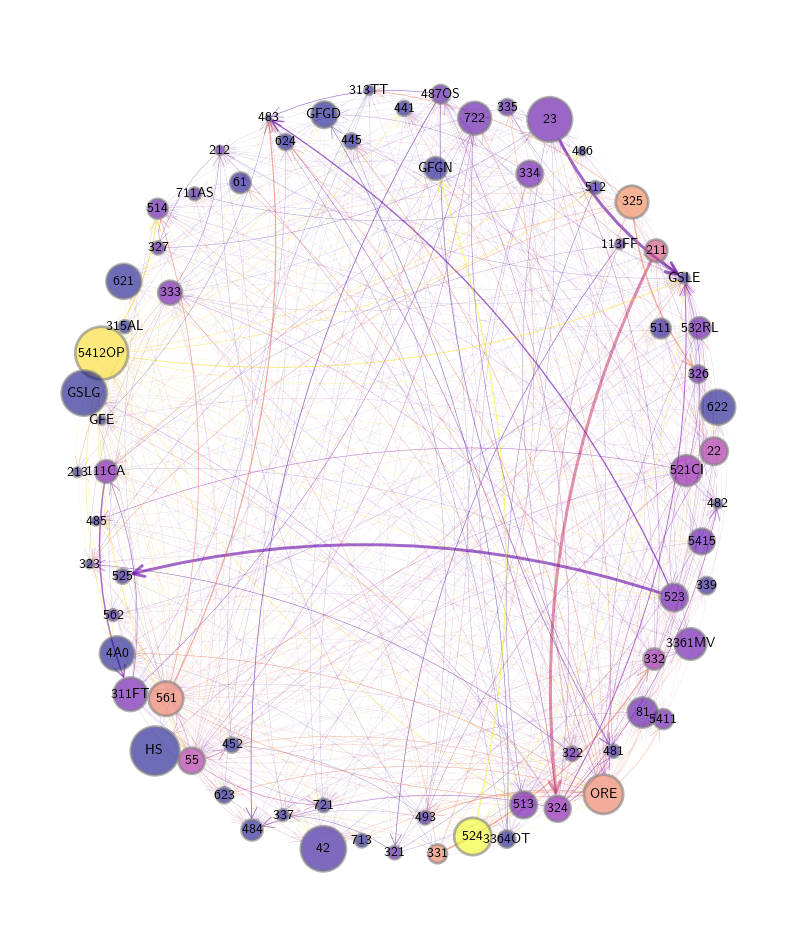

In [22]:
fig, ax = plt.subplots(figsize=(10, 12))
plt.axis("off")
# Remove self-loops
for i in range(A_71.shape[0]):
    A_71[i][i] = 0
qbn_plt.plot_graph(A_71, X_71, ax, codes_71,
              node_size_multiple=0.0005,
              edge_size_multiple=4.0,
              layout_type='spring',
              layout_seed=5432167,
              tol=0.01,
              node_color_list=color_list_71)

if export_figures:
    plt.savefig("figures/input_output_analysis_71.pdf")
plt.show()

###  Network for 114 Australian industry sectors in 2020

Next we load a graph of linkages between 114 Australian sectors in 2020.

In [23]:
codes_114 = ch2_data['au_sectors_114']['codes']
A_114 = ch2_data['au_sectors_114']['adjacency_matrix']
X_114 = ch2_data['au_sectors_114']['total_industry_sales']

Next we calculate our graph's properties. 

We use hub-based eigenvector centrality as our centrality measure for this plot.

In [24]:
centrality_114 = qbn_io.eigenvector_centrality(A_114)
color_list_114 = qbn_io.colorise_weights(centrality_114,beta=False)

Finally we produce the plot.

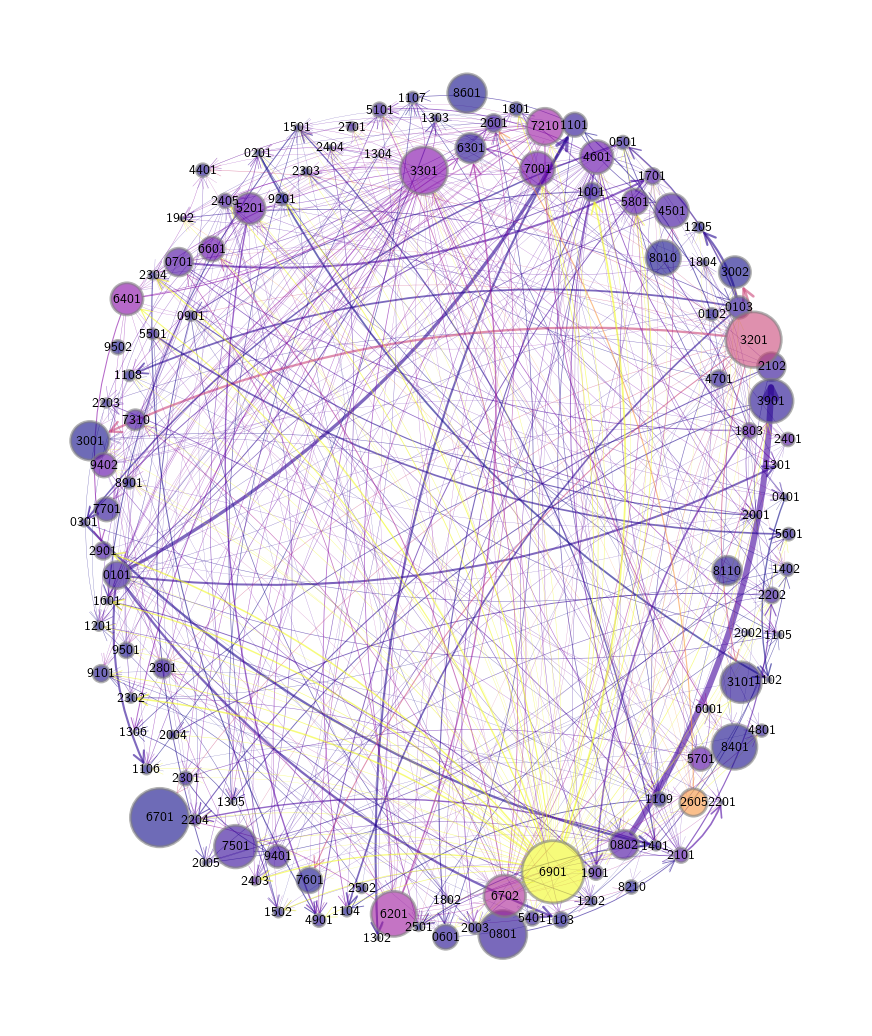

In [25]:
fig, ax = plt.subplots(figsize=(11, 13.2))
plt.axis("off")
# Remove self-loops
for i in range(A_114.shape[0]):
    A_114[i][i] = 0
qbn_plt.plot_graph(A_114, X_114, ax, codes_114,
              node_size_multiple=0.008,
              edge_size_multiple=5.0,
              layout_type='spring',
              layout_seed=5432167,
              tol=0.03,
              node_color_list=color_list_114)

if export_figures:
    plt.savefig("figures/input_output_analysis_aus_114.pdf")
plt.show()

### GDP growth rates and std. deviations (in parentheses) for 8 countries

Here we load a `pandas` DataFrame of GDP growth rates.

In [26]:
gdp_df = ch2_data['gdp_df']
gdp_df.head()

country,Brazil,United States,United Kingdom,France,Japan,Indonesia,Argentina,Mexico,Australia,South Africa
year,,,,,,,,,,
1961,8.6,2.3,2.701314,4.803832,12.043536,5.740646,5.427843,5.000000,2.482330,3.844734
1962,6.6,6.1,1.098696,6.871699,8.908973,1.841978,-0.852022,4.664415,1.294221,6.177931
1963,0.6,4.4,4.859545,6.198635,8.473642,-2.237030,-5.308197,8.106887,6.216180,7.373709
1964,3.4,5.8,5.594811,6.425865,11.676708,3.529698,10.130298,11.905481,6.980166,7.939609
1965,2.4,6.4,2.130333,4.807918,5.819708,1.081589,10.569433,7.100000,5.980140,6.122798


Now we plot the growth rates and calculate their standard deviations.

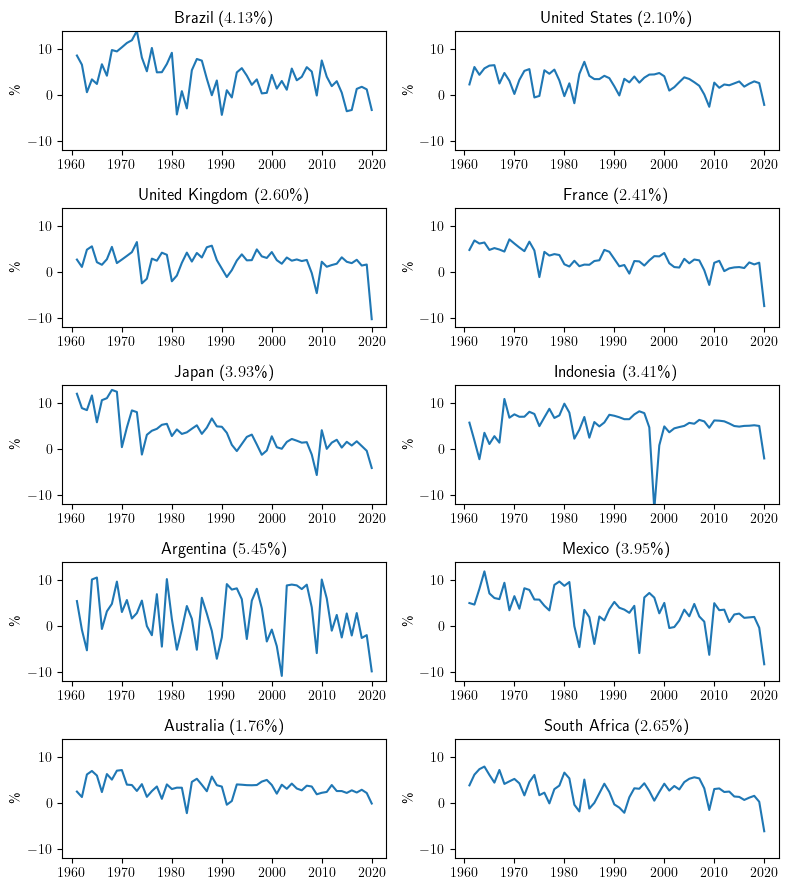

In [29]:
fig, axes = plt.subplots(5, 2, figsize=(8, 9))
axes = axes.flatten()

countries = gdp_df.columns
t = np.asarray(gdp_df.index.astype(float))
series = [np.asarray(gdp_df[country].astype(float)) for country in countries]


for ax, country, gdp_data in zip(axes, countries, series):
    
    ax.plot(t, gdp_data)
    ax.set_title(rf'{country} (${gdp_data.std():1.2f}$\%)' )
    ax.set_ylabel(r'\%')
    ax.set_ylim((-12, 14))

plt.tight_layout()
if export_figures:
    plt.savefig("figures/gdp_growth.pdf")
plt.show()